In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
from statistics import mean as stat_mean

In [2]:
   from google.colab import files
   uploaded = files.upload()

Saving out.csv to out.csv


In [4]:
"""
Для загрузки ohlcv данных можено использовать скрипт fetch_ohlcv.py из этого же репозитория.
Пример использования: python fetch_ohlcv.py -I 5m -N 110000 -o btc_coinbase_5m_110k.csv.

python fetch_ohlcv.py [-N NUM] [-T TICKER] [-I INTERVAL] [-o FILE]
Параметры:
-N Количество записей (по умолчанию: 10000)
-T Торговая пара (по умолчанию: BTC/USDT)
-I Таймфрейм (1m, 5m, 1h и т.д.) (по умолчанию: 5m)
-o Выходной CSV файл (если не указан - вывод в консоль)

Мне удалось добиться RoC-AUC=69 на тестовых выборках для  моделей машинного обучения,
но в случае с нейронной сетью, которую взял за основу из 25 занятия, я уперся в несколько проблем:
1. Не сходиться Generator Loss
2. Generator Loss достигает экстримальных значений
3. Модель изначально почему-то написана для CPU и при переключении на CUDA, получаю что часть данных в CPU, а часть в GPU
4. Также я изучил TSmixter к этому же уроку и мне кажется странным, что тестовая выборка
содержит в себе данные о закрытии цены, что может сказаться на результатах предсказаний
"""
data = pd.read_csv('out.csv')
data['time_dt'] = pd.to_datetime(data['time'])

data['hour'] = data['time_dt'].dt.hour
data['day_of_week'] = data['time_dt'].dt.dayofweek
data['day_of_month'] = data['time_dt'].dt.day
data['month'] = data['time_dt'].dt.month
data.drop(columns=['target', 'time_dt'], inplace=True)
data.set_index('time', inplace=True)
data = data.iloc[1:, :]
data['target'] = data['close']
data = data.drop(columns=['close'], axis=1)
data

,open,high,low,volume,open_ratio_1,open_log_diff_1,open_momentum_5,open_roc_5,open_ema_5,high_ratio_1,...,sol_doji,sol_engulfing,sol_rolling_vol_10,sol_range,sol_range_pct,hour,day_of_week,day_of_month,month,target
time,,,,,,,,,,,,,,,,,,,,,
2025-03-18 09:58:00+00:00,82886.27,82886.27,82801.39,0.024308,1.000061,0.000061,-129.72,-0.156259,82920.913300,0.999993,...,0,0,0.001241,0.09,0.000721,9,1,18,3,82801.39
2025-03-18 10:06:00+00:00,82838.16,82857.22,82838.16,0.154500,0.999033,-0.000968,27.20,0.032846,82865.354281,0.999192,...,0,0,0.001333,0.12,0.000962,10,1,18,3,82857.22
2025-03-18 10:15:00+00:00,82709.48,82717.51,82613.55,1.297885,0.998875,-0.001125,-136.60,-0.164884,82776.654587,0.998972,...,0,0,0.001454,0.32,0.002577,10,1,18,3,82695.77
2025-03-18 10:18:00+00:00,82623.03,82623.03,82592.84,0.040534,0.999089,-0.000912,-154.62,-0.186790,82691.406174,0.999089,...,0,0,0.001461,0.14,0.001129,10,1,18,3,82592.84
2025-03-18 10:24:00+00:00,82700.72,82729.15,82700.72,0.066341,1.000438,0.000438,77.69,0.094029,82673.583529,1.000396,...,0,0,0.001627,0.17,0.001369,10,1,18,3,82727.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-26 18:00:00+00:00,109165.78,109165.78,109086.68,0.064524,1.000193,0.000193,107.91,0.098947,109139.389645,0.999969,...,0,0,0.000901,0.10,0.000576,18,0,26,5,109086.68
2025-05-26 18:02:00+00:00,109090.40,109090.41,109041.09,0.029468,0.999309,-0.000691,-38.38,-0.035169,109123.059763,0.999310,...,100,0,0.000731,0.01,0.000058,18,0,26,5,109041.09
2025-05-26 18:08:00+00:00,109137.79,109137.79,109092.93,0.310429,0.999538,-0.000462,-27.99,-0.025640,109141.733904,0.999538,...,0,0,0.001537,0.06,0.000344,18,0,26,5,109126.68


In [5]:
# Data subset for tuning
new_data = data
#new_data = data.iloc[:250,]

In [6]:
# Convert data to numpy array
dataset = new_data.values

# Get training set size 80:10:10 split
training_data_len = math.ceil(len(dataset) * 0.8)
testing_data_len = math.ceil((len(dataset) - training_data_len)*0.5)
val_data_len = len(dataset) - training_data_len - testing_data_len
print('Training data length: ' + str(training_data_len))
print('Testing data length: ' + str(testing_data_len))
print('Validation data length: ' + str(val_data_len))

Training data length: 25175
Testing data length: 3147
Validation data length: 3146


In [7]:
# Scaler for data
scaler = MinMaxScaler(feature_range=(0,1))
# scaled_data = scaler.fit_transform(dataset)


In [8]:
# Create training dataset
train_data = dataset[0:training_data_len,:]

# Split to x_train and y_train
x_train = train_data[:,:131]
y_train = train_data[:,131]

#y_train = train_data['close']
#x = data.iloc[:, :132].values # остальные признаки кроме цены закрытия
#x_train = train_data.drop(columns=['close'], axis=1)

# Create scaled test dataset
test_and_val_data = dataset[training_data_len:,:]

# Split to x_val and y_val
x_val = test_and_val_data[0:testing_data_len,:131]
y_val = test_and_val_data[0:testing_data_len,131]

# Split to x_test and y_test
x_test = test_and_val_data[testing_data_len:,:131]
y_test = test_and_val_data[testing_data_len:,131]

# Show shapes of sets
print('x_train shape: ' + str(x_train.shape))
print('y_train shape: ' + str(y_train.shape))
print()
print('x_val shape: ' + str(x_val.shape))
print('y_val shape: ' + str(y_val.shape))
print()
print('x_test shape: ' + str(x_test.shape))
print('y_test shape: ' + str(y_test.shape))

x_train shape: (25175, 131)
y_train shape: (25175,)

x_val shape: (3147, 131)
y_val shape: (3147,)

x_test shape: (3146, 131)
y_test shape: (3146,)


In [9]:
x_train

array([[8.2886270e+04, 8.2886270e+04, 8.2801390e+04, ..., 1.0000000e+00,
        1.8000000e+01, 3.0000000e+00],
       [8.2838160e+04, 8.2857220e+04, 8.2838160e+04, ..., 1.0000000e+00,
        1.8000000e+01, 3.0000000e+00],
       [8.2709480e+04, 8.2717510e+04, 8.2613550e+04, ..., 1.0000000e+00,
        1.8000000e+01, 3.0000000e+00],
       ...,
       [1.0338909e+05, 1.0338909e+05, 1.0319771e+05, ..., 3.0000000e+00,
        1.5000000e+01, 5.0000000e+00],
       [1.0321389e+05, 1.0325571e+05, 1.0319907e+05, ..., 3.0000000e+00,
        1.5000000e+01, 5.0000000e+00],
       [1.0326955e+05, 1.0328575e+05, 1.0319838e+05, ..., 3.0000000e+00,
        1.5000000e+01, 5.0000000e+00]])

In [10]:
# Splits preview
print(y_train)
print(y_val)
print(y_test)

[ 82801.39  82857.22  82695.77 ... 103210.67 103255.71 103198.38]
[103216.79 103174.89 103173.56 ... 109591.99 109637.34 109606.99]
[109563.51 109528.52 109574.38 ... 109126.68 109073.21 109137.94]


In [11]:
# Convert sets to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

x_val = np.array(x_test)
y_val = np.array(y_test)

x_test = np.array(x_test)
y_test = np.array(y_test)

# Scale data
scaled_data = scaler.fit_transform(dataset)

x_train = scaler.fit_transform(x_train)
y_train = scaler.fit_transform(y_train.reshape(-1,1))

x_val = scaler.fit_transform(x_val)
y_val = scaler.fit_transform(y_val.reshape(-1,1))

x_test = scaler.fit_transform(x_test)
y_test = scaler.fit_transform(y_test.reshape(-1,1))

x_train

array([[0.26681703, 0.26218393, 0.26680656, ..., 0.16666667, 0.56666667,
        0.        ],
       [0.26526884, 0.26125013, 0.26798757, ..., 0.16666667, 0.56666667,
        0.        ],
       [0.26112788, 0.25675921, 0.26077333, ..., 0.16666667, 0.56666667,
        0.        ],
       ...,
       [0.92660441, 0.92123897, 0.92191469, ..., 0.5       , 0.46666667,
        1.        ],
       [0.92096641, 0.91695152, 0.92195837, ..., 0.5       , 0.46666667,
        1.        ],
       [0.92275757, 0.91791715, 0.92193621, ..., 0.5       , 0.46666667,
        1.        ]])

In [12]:
train_x = x_train
train_y = y_train
val_x = x_val
val_y = y_val
test_x = x_test
test_y = y_test

# Code below modified from: https://github.com/ChickenBenny/Stock-prediction-with-GAN-and-WGAN/blob/main/wgan-gp_demo.ipynb

In [13]:
def sliding_window(x, y, window):
    x_ = []
    y_ = []
    y_gan = []
    for i in range(window, x.shape[0]):
        tmp_x = x[i - window: i, :]
        tmp_y = y[i]
        tmp_y_gan = y[i - window: i + 1]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan.append(tmp_y_gan)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan = torch.from_numpy(np.array(y_gan)).float()
    return x_, y_, y_gan

# For VAE
# train_x = np.concatenate((train_x, VAE_train_x.cpu().detach().numpy()), axis = 1)
# test_x = np.concatenate((test_x, VAE_test_x.cpu().detach().numpy()), axis = 1)

train_x_slide, train_y_slide, train_y_gan = sliding_window(train_x, train_y, 3)
val_x_slide, val_y_slide, val_y_gan = sliding_window(val_x, val_y, 3)
test_x_slide, test_y_slide, test_y_gan = sliding_window(test_x, test_y, 3)
print(f'train_x: {train_x_slide.shape} train_y: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'val_x: {val_x_slide.shape} val_y: {val_y_slide.shape} val_y_gan: {val_y_gan.shape}')
print(f'test_x: {test_x_slide.shape} test_y: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}')


train_x: torch.Size([25172, 3, 131]) train_y: torch.Size([25172, 1]) train_y_gan: torch.Size([25172, 4, 1])
val_x: torch.Size([3143, 3, 131]) val_y: torch.Size([3143, 1]) val_y_gan: torch.Size([3143, 4, 1])
test_x: torch.Size([3143, 3, 131]) test_y: torch.Size([3143, 1]) test_y_gan: torch.Size([3143, 4, 1])


In [14]:
# Build Generator: Long Short Term Memory Network
class Generator(nn.Module):
    def __init__(self, input_size):
        super().__init__()

        #Build LSTM
        self.LSTM = nn.LSTM(input_size=input_size, hidden_size=512, num_layers=1, batch_first = True)
        self.output_layer = nn.Linear(512, 1, bias=False)

#         self.gru_1 = nn.GRU(input_size, 1024, batch_first = True)
#         self.gru_2 = nn.GRU(1024, 512, batch_first = True)
#         self.gru_3 = nn.GRU(512, 256, batch_first = True)
#         self.linear_1 = nn.Linear(256, 128)
#         self.linear_2 = nn.Linear(128, 64)
#         self.linear_3 = nn.Linear(64, 1)
#         self.dropout = nn.Dropout(0.2)


    def forward(self, x):
        # initialize hidden state
        h0 = torch.zeros(1, x.size(0), 512).requires_grad_()

        # initialize cell state
        c0 = torch.zeros(1, x.size(0), 512).requires_grad_()

        # Data Path through NN
        LSTM_out, (LSTM_hn, LSTM_cn) = self.LSTM(x, (h0.detach(), c0.detach()))
        output = self.output_layer(LSTM_out[:, -1, :])
        return output



#         use_cuda = 1
#         device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
#         h0 = torch.zeros(1, x.size(0), 1024).to(device)
#         out_1, _ = self.gru_1(x, h0)
#         out_1 = self.dropout(out_1)
#         h1 = torch.zeros(1, x.size(0), 512).to(device)
#         out_2, _ = self.gru_2(out_1, h1)
#         out_2 = self.dropout(out_2)
#         h2 = torch.zeros(1, x.size(0), 256).to(device)
#         out_3, _ = self.gru_3(out_2, h2)
#         out_3 = self.dropout(out_3)
#         out_4 = self.linear_1(out_3[:, -1, :])
#         out_5 = self.linear_2(out_4)
#         out_6 = self.linear_3(out_5)
#         return out_6

# Build Discriminator: Convolutional Neural Network Version 3.2
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # 1-Dimensional Convolutional Layers with LeakyReLU and Batch Normalization
        self.conv_layer0 = nn.Conv1d(4, 32, kernel_size=5, stride=1, padding='same')
        self.conv_layer1 = nn.Conv1d(32, 64, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer2 = nn.LeakyReLU(0.01)
        self.conv_layer3 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer4 = nn.LeakyReLU(0.01)
#         self.batchnorm_layer5 = nn.BatchNorm1d(128)
        self.conv_layer6 = nn.Conv1d(128, 256, kernel_size=5, stride=1, padding='same')
        self.leakyrelu_layer7 = nn.LeakyReLU(0.01)
#         self.batchnorm_layer8 = nn.BatchNorm1d(256)

        # Fully Connected Layers
        self.dense_layer9 = nn.Linear(256, 256, bias=False)
#         self.batchnorm_layer10 = nn.BatchNorm1d(256)
        self.leakyrelu_layer11 = nn.LeakyReLU(0.01)
        self.dense_layer12 = nn.Linear(256, 256, bias=False)
        self.activation_layer13 = nn.ReLU()
        self.dense_layer14 = nn.Linear(256, 1)


    def forward(self, x):
        conv_layer0 = self.conv_layer0(x)
        conv_layer1 = self.conv_layer1(conv_layer0)
        leakyrelu_layer2 = self.leakyrelu_layer2(conv_layer1)
        conv_layer3 = self.conv_layer3(leakyrelu_layer2)
        leakyrelu_layer4 = self.leakyrelu_layer4(conv_layer3)
#         batchnorm_layer5 = self.batchnorm_layer5(leakyrelu_layer4)
        conv_layer6 = self.conv_layer6(leakyrelu_layer4)
        leakyrelu_layer7 = self.leakyrelu_layer7(conv_layer6)
#         batchnorm_layer8 = self.batchnorm_layer8(leakyrelu_layer7)
        reshape =  leakyrelu_layer7.reshape(leakyrelu_layer7.shape[0], leakyrelu_layer7.shape[1])
        dense_layer9 = self.dense_layer9(reshape)
#         batchnorm_layer10 = self.batchnorm_layer10(dense_layer9)
        leakyrelu_layer11 = self.leakyrelu_layer11(dense_layer9)
        dense_layer12 = self.dense_layer12(leakyrelu_layer11)
        activation_layer13 = self.activation_layer13(dense_layer12)
        dense_layer14 = self.dense_layer14(activation_layer13)
        return dense_layer14

In [16]:
# Gradient Penalty Implementation
# Modified From: https://github.com/Zeleni9/pytorch-wgan/blob/master/models/wgan_gradient_penalty.py
def calculate_gradient_penalty(critic, real_data, fake_data, device='cpu'):
    eta = torch.FloatTensor(fake_data.size(0),1,1).uniform_(0,1)
    eta = eta.expand(fake_data.size(0), real_data.size(1), real_data.size(2)).to(device)

#     print(eta.size())
#     print(fake_data.size())
    interpolated = eta * real_data + ((1 - eta) * fake_data)

    # define it to calculate gradient
    interpolated = Variable(interpolated, requires_grad=True)

    # calculate probability of interpolated examples
    prob_interpolated = critic(interpolated)

    # calculate gradients of probabilities with respect to examples
    gradients = torch_grad(outputs=prob_interpolated, inputs=interpolated,
                           grad_outputs=torch.ones(
                               prob_interpolated.size()).to(device),
                           create_graph=True, retain_graph=True)[0]

    grad_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * 10
    return grad_penalty

In [17]:
"""
Тут LossG не сходится и имеет экстримально большое значение по модулю.
Хотя должно колебаться в пределах [0, 10]
# [1/100] LossD: 1129.6416523552325 LossG:-636.2289615252521
# [2/100] LossD: 2.3326607422459347 LossG:-1140.8042913675308
# [3/100] LossD: 1.7219701425947278 LossG:-1111.2937738895416
# [4/100] LossD: 1.3390578816579364 LossG:-1108.787337899208
# [5/100] LossD: 1.3342405664079706 LossG:-1086.0665410757065
# [6/100] LossD: 1.2527055619866587 LossG:-1079.790892481804
# [7/100] LossD: 1.2652017953641916 LossG:-1094.1611658334732
# [8/100] LossD: 1.1942455293610692 LossG:-1096.6618312597275
# [9/100] LossD: 1.1241491200089513 LossG:-1095.4795062541962
# [10/100] LossD: 1.1501293171932048 LossG:-1080.2926394939423
# [11/100] LossD: 1.144598199356551 LossG:-1079.0996309518814
# [12/100] LossD: 1.1026750896198791 LossG:-1083.8356518745422
# [13/100] LossD: 1.0988639082315785 LossG:-1108.1718254089355
# [14/100] LossD: 1.109403076399758 LossG:-1124.7842386960983
# [15/100] LossD: 1.1229793308011722 LossG:-1134.980587363243
# [16/100] LossD: 1.080734658815345 LossG:-1123.7064027786255
# [17/100] LossD: 1.061530488095741 LossG:-1109.94615483284
# [18/100] LossD: 1.1089050557748124 LossG:-1092.963868021965
# [19/100] LossD: 1.0856583572590353 LossG:-1090.4905297756195
# [20/100] LossD: 1.0919503660734335 LossG:-1104.2141193151474
# [21/100] LossD: 1.081066058453871 LossG:-1107.9895062446594
"""
use_cuda = 0
device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

from sklearn.model_selection import ParameterGrid

# param_grid = {'epochs':[100, 125, 150, 175, 200, 250],
#               'learning_rate': [0.0001, 0.00001],
#               'batch_size' : [32, 64, 128],
#               'critic_iterations' :[1,2,3,4,5]}
param_grid = {'epochs':[100],
              'learning_rate': [0.0001],
              'batch_size' : [32],
              'critic_iterations' :[1]}

grid = ParameterGrid(param_grid)

full_params_list = list()
iteration_count = 0

for params in grid:
    iteration_count+=1
    print(f'---------- Starting training with new params [{iteration_count}/{len(grid)}] ----------')
    print('')
    print(params)

    # Hyperparameters set by grid search
    batch_size = params['batch_size']
    learning_rate = params['learning_rate']
    num_epochs = params['epochs']
    critic_iterations = params['critic_iterations']

    # Data Loader
    trainDataloader = DataLoader(TensorDataset(train_x_slide, train_y_gan), batch_size = batch_size, shuffle = False)

    # Build Models
    modelG = Generator(131).to(device)
    modelD = Discriminator().to(device)

    # Build Optimizers
    optimizerG = torch.optim.RMSprop(modelG.parameters(), lr=learning_rate, alpha = 0.9)
    optimizerD = torch.optim.RMSprop(modelD.parameters(), lr=learning_rate, alpha = 0.9)

    # optimizerG = torch.optim.Adam(modelG.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)
    # optimizerD = torch.optim.Adam(modelD.parameters(), lr = learning_rate, betas = (0.0, 0.9), weight_decay = 1e-3)

    # History Storage
    histG = np.zeros(num_epochs)
    histD = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        loss_G = []
        loss_D = []
        for (x, y) in trainDataloader:
            x = x.to(device)
            y = y.to(device)

            lossD_arr = []
            costG = 0

            # Generate Fake Data
            fake_data = modelG(x)
            fake_data = torch.cat([fake_data.reshape(-1, 1, 1), y[:, :3, :]], axis = 1)

            for i in range(critic_iterations):
                # Train Discriminator
                critic_loss_real = 0
                critic_loss_fake = 0
                critic_wasserstein = 0


                    # Train on real closing prices
                real_data = y
                critic_loss_real = modelD(real_data)
                critic_loss_real = torch.mean(critic_loss_real)

                    # Train on fake closing prices
                critic_loss_fake = modelD(fake_data)
                critic_loss_fake = torch.mean(critic_loss_fake)


                    # Calculate Gradient Penalty
                gradient_penalty = calculate_gradient_penalty(modelD, real_data, fake_data)

                    # Compute Loss
                lossD = critic_loss_fake - critic_loss_real + gradient_penalty

                    # Zero Gradients
                modelD.zero_grad()

                    # Back Propogation
                lossD.backward(retain_graph = True)
                lossD_arr.append(lossD)
                critic_wasserstein = -(critic_loss_real - critic_loss_fake)

                # Optimizer step
                optimizerD.step()

            # Train Generator

                # Compute Loss
            lossG = modelD(fake_data)
            lossG = -torch.mean(lossG)
            modelG.zero_grad()
            lossG.backward()
            optimizerG.step()

            # Append Losses
            loss_D.append((torch.mean(torch.stack(lossD_arr))).item())
            loss_G.append(lossG.item())

        # Print Losses
        histG[epoch] = sum(loss_G)
        histD[epoch] = sum(loss_D)
        print(f'[{epoch+1}/{num_epochs}] LossD: {sum(loss_D)} LossG:{sum(loss_G)}')

    #Evaluate results for current params
    modelG.eval()
    pred_y_train = modelG(train_x_slide.to(device))
    pred_y_val = modelG(val_x_slide.to(device))

    y_train_true = scaler.inverse_transform(train_y_slide)
    y_train_pred = scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

    y_val_true = scaler.inverse_transform(val_y_slide)
    y_val_pred = scaler.inverse_transform(pred_y_val.cpu().detach().numpy())

    train_RMSE = math.sqrt(mean_squared_error(y_train_true, y_train_pred))
    val_RMSE = math.sqrt(mean_squared_error(y_val_true, y_val_pred))

    #Store RMSE values for min search later
    params['train_RMSE'] = train_RMSE
    params['val_RMSE'] = val_RMSE
    print('train_RMSE, val_RMSE = {x:.3f},{y:.3f}'.format(x = train_RMSE, y = val_RMSE))
    full_params_list.append(params)
    print('---------- Ending training with new params ----------')
    print()

---------- Starting training with new params [1/1] ----------

{'batch_size': 32, 'critic_iterations': 1, 'epochs': 1, 'learning_rate': 0.0001}
[1/1] LossD: 852.8755696505541 LossG:-844.572062993655
train_RMSE, val_RMSE = 1295.613,1431.573
---------- Ending training with new params ----------



Text(0.5, 0, 'Epochs')

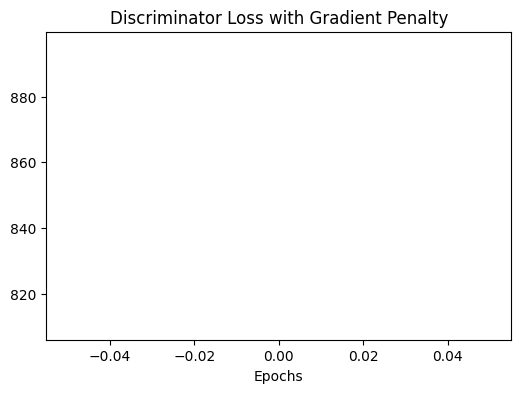

In [18]:
plt.figure(figsize = (6, 4))
plt.plot(histD, color = 'black', label = 'Discriminator Loss')
plt.title('Discriminator Loss with Gradient Penalty')
plt.xlabel('Epochs')

Text(0.5, 0, 'Epochs')

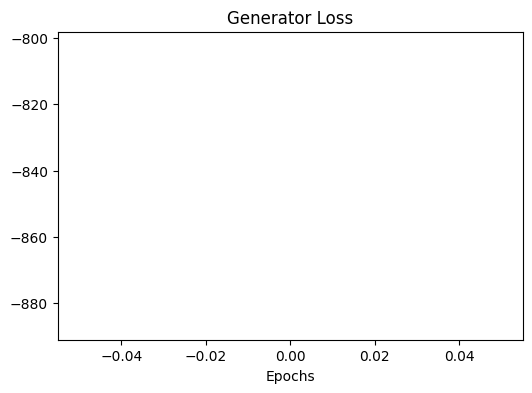

In [19]:
plt.figure(figsize = (6, 4))
plt.plot(histG, color = 'blue', label = 'Generator Loss')
plt.title('Generator Loss')
plt.xlabel('Epochs')

In [20]:
modelG.eval()
pred_y_train = modelG(train_x_slide.to(device))
pred_y_test = modelG(test_x_slide.to(device))

y_train_true = scaler.inverse_transform(train_y_slide)
y_train_pred = scaler.inverse_transform(pred_y_train.cpu().detach().numpy())

y_test_true = scaler.inverse_transform(test_y_slide)
y_test_pred = scaler.inverse_transform(pred_y_test.cpu().detach().numpy())

Training dataset RMSE:1295.6131047652875


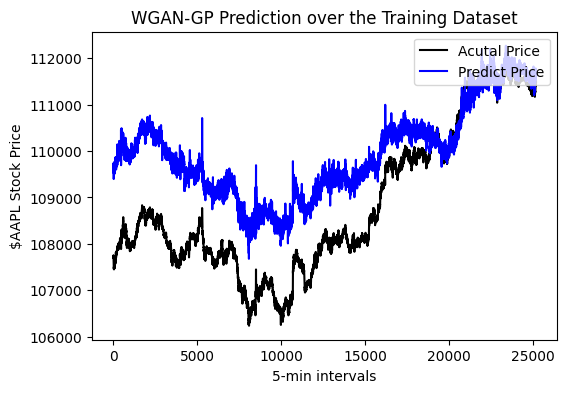

In [21]:

plt.figure(figsize=(6, 4))
plt.plot(y_train_true, color = 'black', label = 'Acutal Price')
plt.plot(y_train_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP Prediction over the Training Dataset')
plt.ylabel('$AAPL Stock Price')
plt.xlabel('5-min intervals')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Testing dataset RMSE:1431.5729791458778


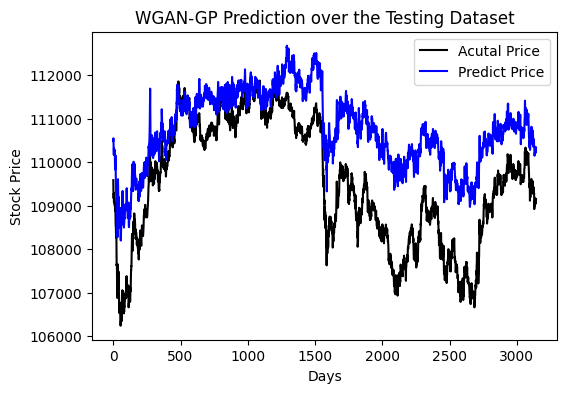

In [22]:

plt.figure(figsize=(6, 4))
plt.plot(y_test_true, color = 'black', label = 'Acutal Price')
plt.plot(y_test_pred, color = 'blue', label = 'Predict Price')
plt.title('WGAN-GP Prediction over the Testing Dataset')
plt.ylabel('Stock Price')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred)
RMSE = math.sqrt(MSE)
print(f'Testing dataset RMSE:{RMSE}')